In [1]:
import warnings; warnings.filterwarnings("ignore", message="Initializing zero-element tensors is a no-op")
import pandas as pd
import torch

from eval_utils import get_pairs, eval_epochs

import sys
sys.path.insert(0, '../')

from utils import aug_transform, simple_transform
from models.mini_inception_resnet_v1 import MiniInceptionResNetV1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGES_PATH = '../data/'
EPOCHS_PATH = '../checkpoints/'

In [2]:
test_df = pd.read_csv('../data/mnist_test.csv')
print(f'Test data shape: {test_df.shape}')

pairs = get_pairs(test_df, 1000)
print(f'Pairs shape: {pairs.shape}')

Test data shape: (10000, 785)
Pairs shape: (1000, 3)


In [3]:
pairs.head(1)

,img1,img2,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


Calculating distances: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


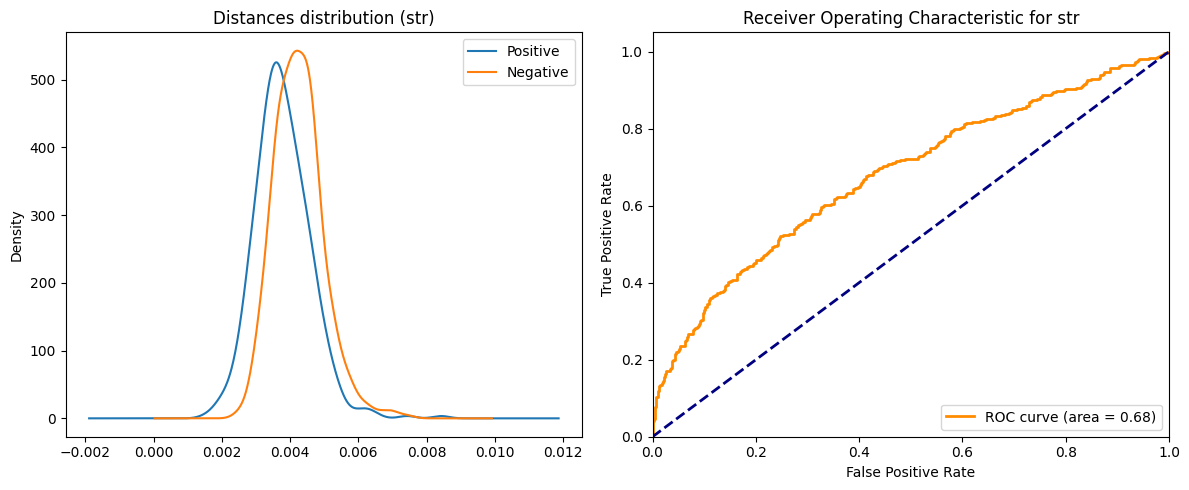

Target FAR: 1e-02 | Threshold: 0.0029
[epoch_1.pt] Accuracy: 0.5540
[epoch_1.pt] VAL: 0.1180 | FAR: 0.0100

[epoch_1.pt] Positive mean: 0.0038 ± 0.0008
[epoch_1.pt] Negative mean: 0.0043 ± 0.0007


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 74.48it/s]


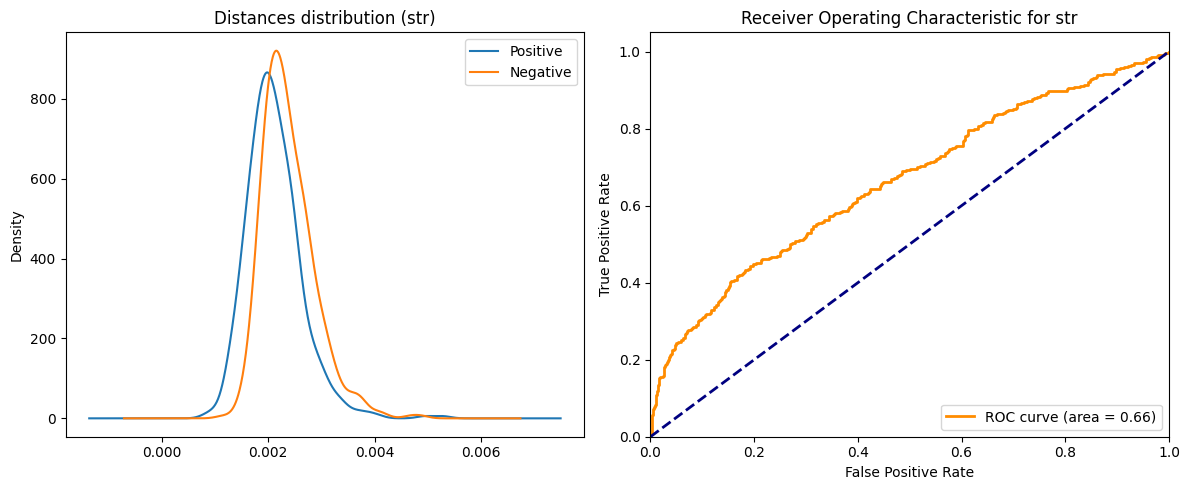

Target FAR: 1e-02 | Threshold: 0.0016
[epoch_2.pt] Accuracy: 0.5480
[epoch_2.pt] VAL: 0.1060 | FAR: 0.0100

[epoch_2.pt] Positive mean: 0.0021 ± 0.0005
[epoch_2.pt] Negative mean: 0.0024 ± 0.0005


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 83.57it/s]


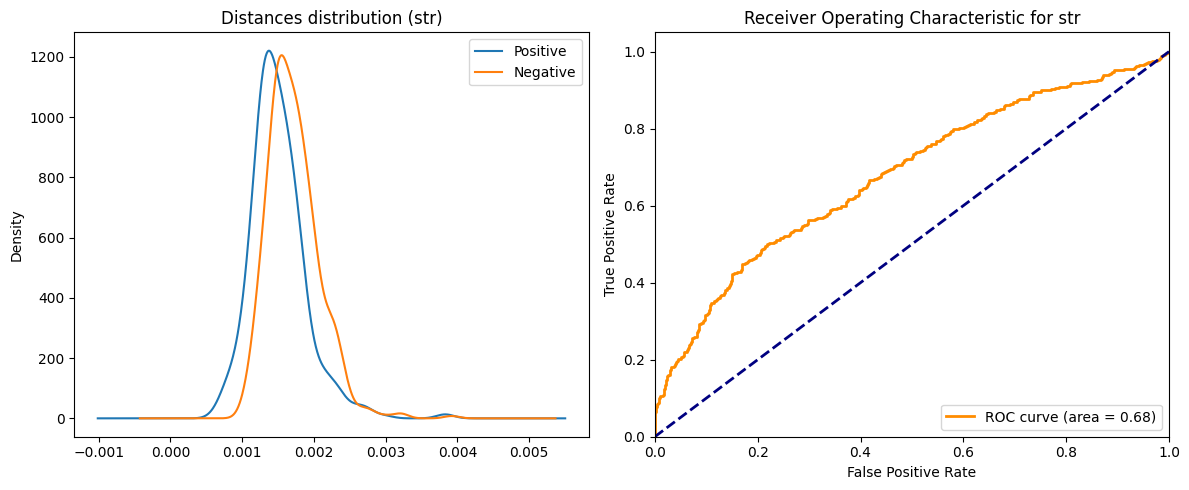

Target FAR: 1e-02 | Threshold: 0.0011
[epoch_3.pt] Accuracy: 0.5470
[epoch_3.pt] VAL: 0.1040 | FAR: 0.0100

[epoch_3.pt] Positive mean: 0.0015 ± 0.0004
[epoch_3.pt] Negative mean: 0.0017 ± 0.0004


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 91.88it/s]


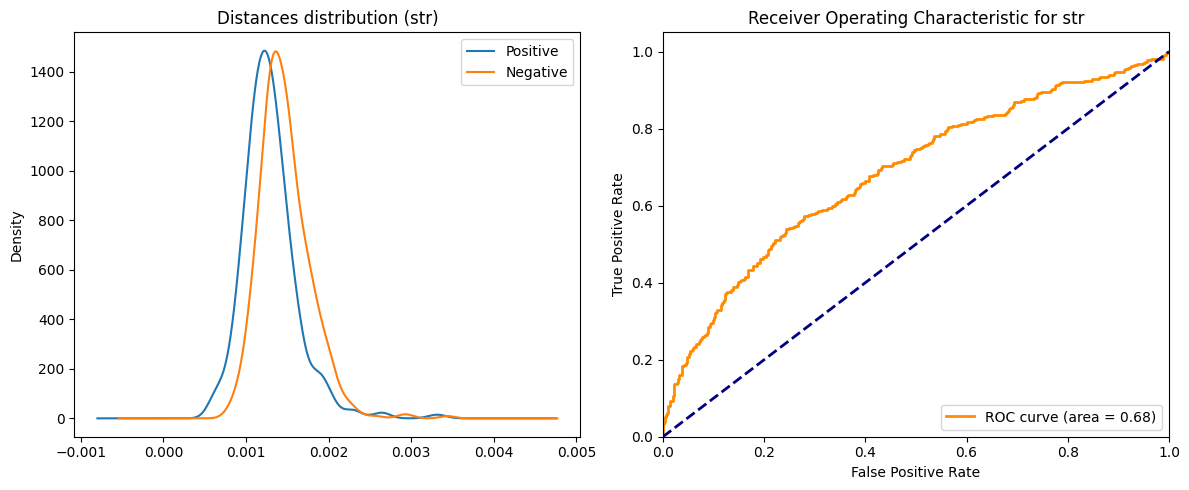

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_4.pt] Accuracy: 0.5340
[epoch_4.pt] VAL: 0.0780 | FAR: 0.0100

[epoch_4.pt] Positive mean: 0.0013 ± 0.0003
[epoch_4.pt] Negative mean: 0.0015 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 87.03it/s]


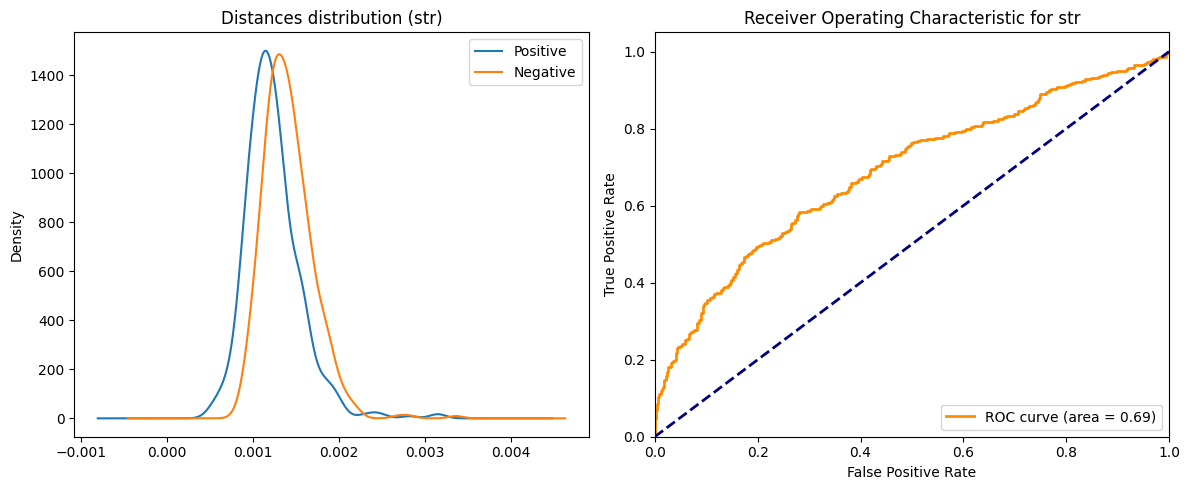

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_5.pt] Accuracy: 0.5500
[epoch_5.pt] VAL: 0.1080 | FAR: 0.0080

[epoch_5.pt] Positive mean: 0.0012 ± 0.0003
[epoch_5.pt] Negative mean: 0.0014 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 90.09it/s]


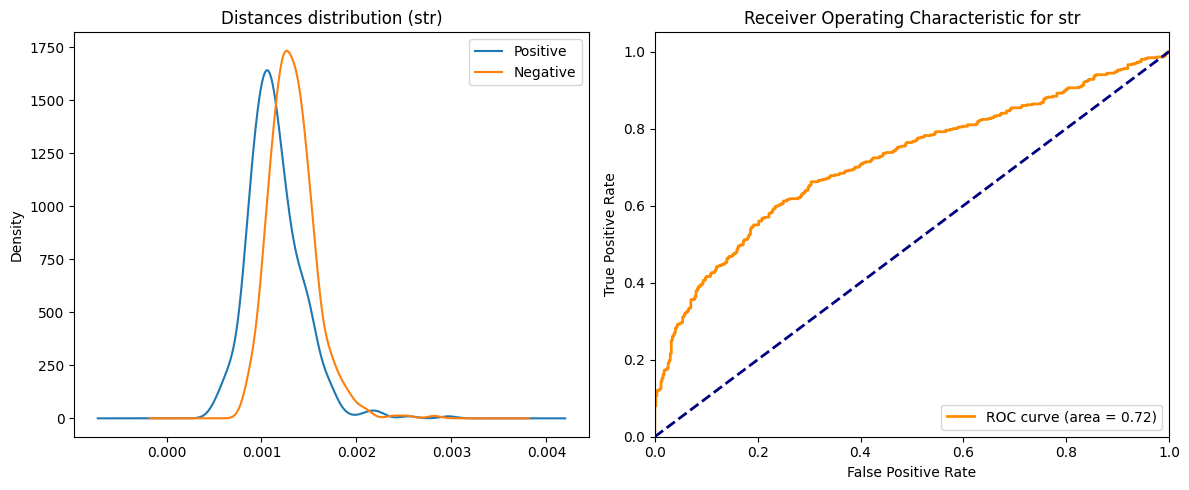

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_6.pt] Accuracy: 0.5570
[epoch_6.pt] VAL: 0.1220 | FAR: 0.0080

[epoch_6.pt] Positive mean: 0.0011 ± 0.0003
[epoch_6.pt] Negative mean: 0.0013 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 94.35it/s]


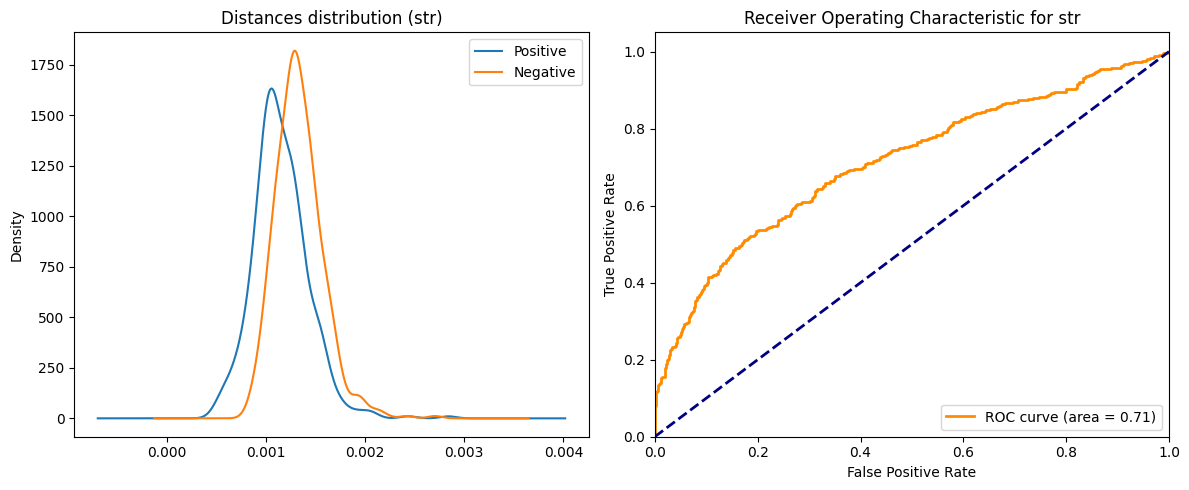

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_7.pt] Accuracy: 0.5640
[epoch_7.pt] VAL: 0.1380 | FAR: 0.0100

[epoch_7.pt] Positive mean: 0.0011 ± 0.0003
[epoch_7.pt] Negative mean: 0.0013 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 88.50it/s]


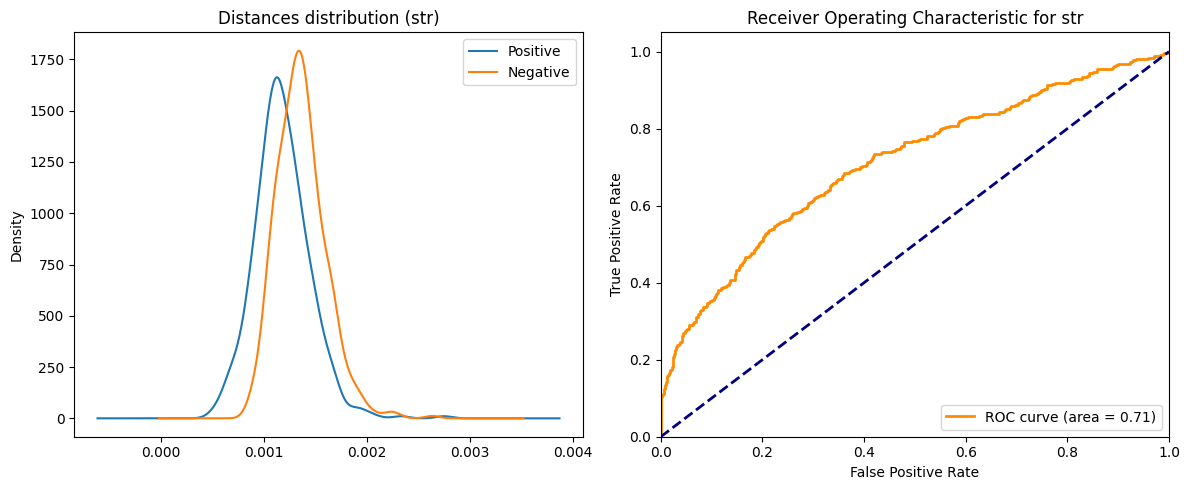

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_8.pt] Accuracy: 0.5650
[epoch_8.pt] VAL: 0.1400 | FAR: 0.0100

[epoch_8.pt] Positive mean: 0.0012 ± 0.0003
[epoch_8.pt] Negative mean: 0.0014 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 85.16it/s]


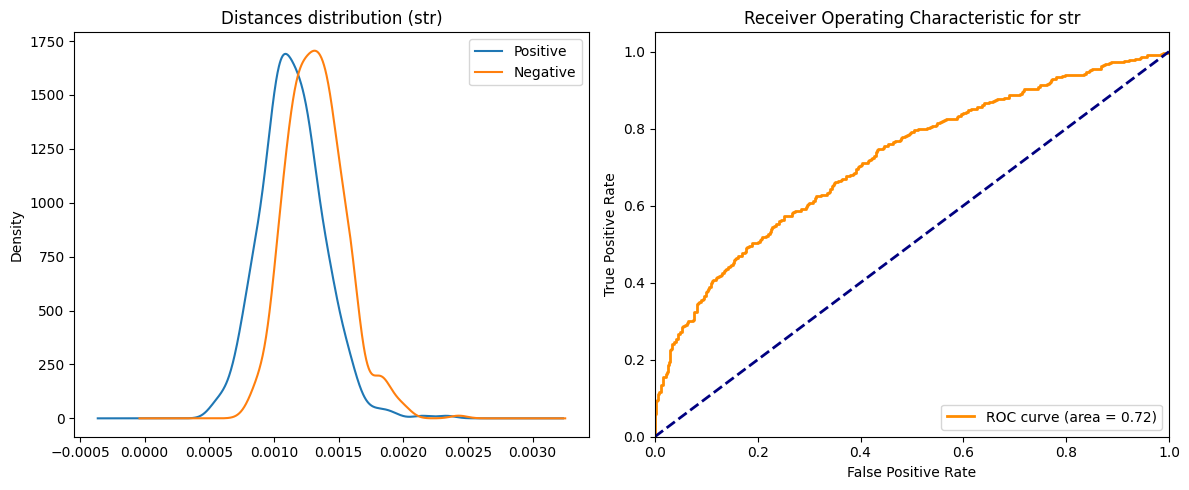

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_9.pt] Accuracy: 0.5530
[epoch_9.pt] VAL: 0.1140 | FAR: 0.0080

[epoch_9.pt] Positive mean: 0.0011 ± 0.0002
[epoch_9.pt] Negative mean: 0.0013 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 90.19it/s]


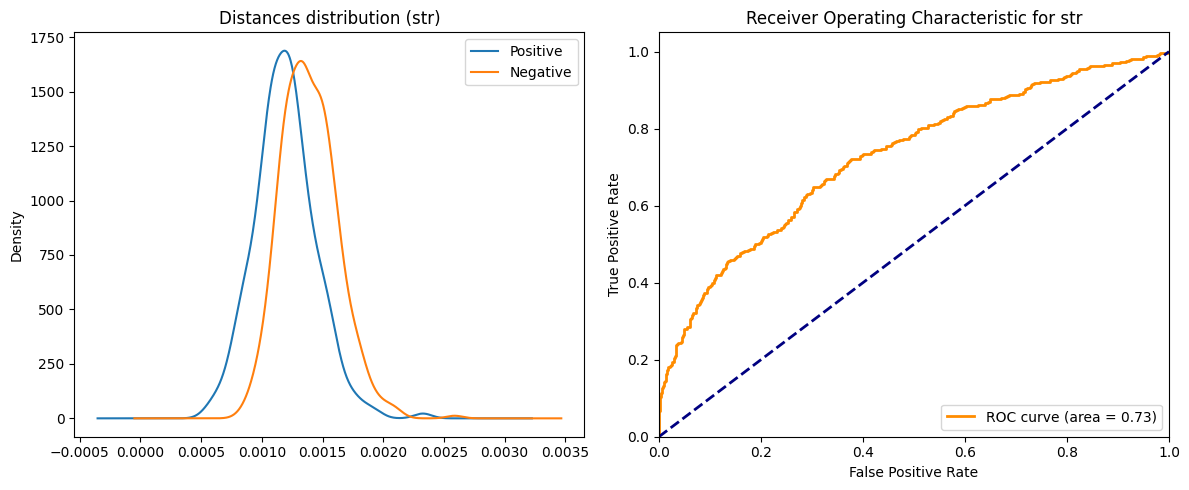

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_10.pt] Accuracy: 0.5650
[epoch_10.pt] VAL: 0.1400 | FAR: 0.0100

[epoch_10.pt] Positive mean: 0.0012 ± 0.0003
[epoch_10.pt] Negative mean: 0.0014 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 90.82it/s]


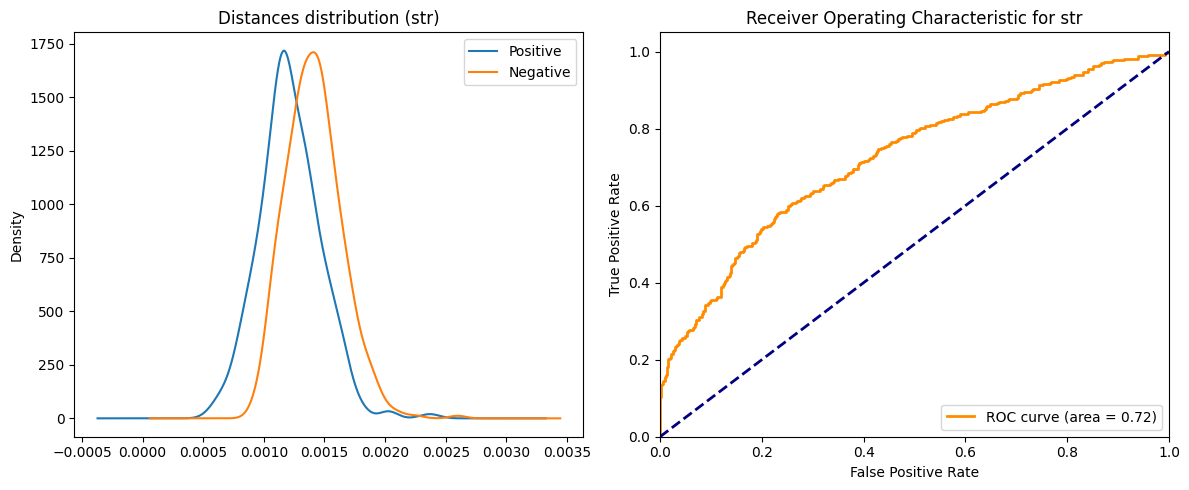

Target FAR: 1e-02 | Threshold: 0.0010
[epoch_11.pt] Accuracy: 0.5720
[epoch_11.pt] VAL: 0.1540 | FAR: 0.0100

[epoch_11.pt] Positive mean: 0.0012 ± 0.0003
[epoch_11.pt] Negative mean: 0.0014 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 81.17it/s] 


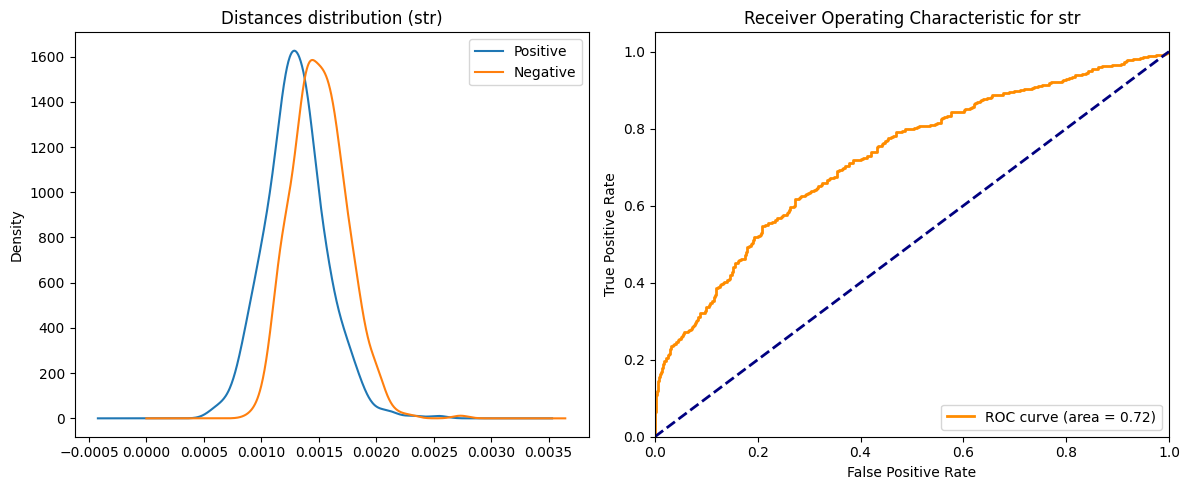

Target FAR: 1e-02 | Threshold: 0.0010
[epoch_12.pt] Accuracy: 0.5760
[epoch_12.pt] VAL: 0.1620 | FAR: 0.0100

[epoch_12.pt] Positive mean: 0.0013 ± 0.0003
[epoch_12.pt] Negative mean: 0.0015 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 80.18it/s]


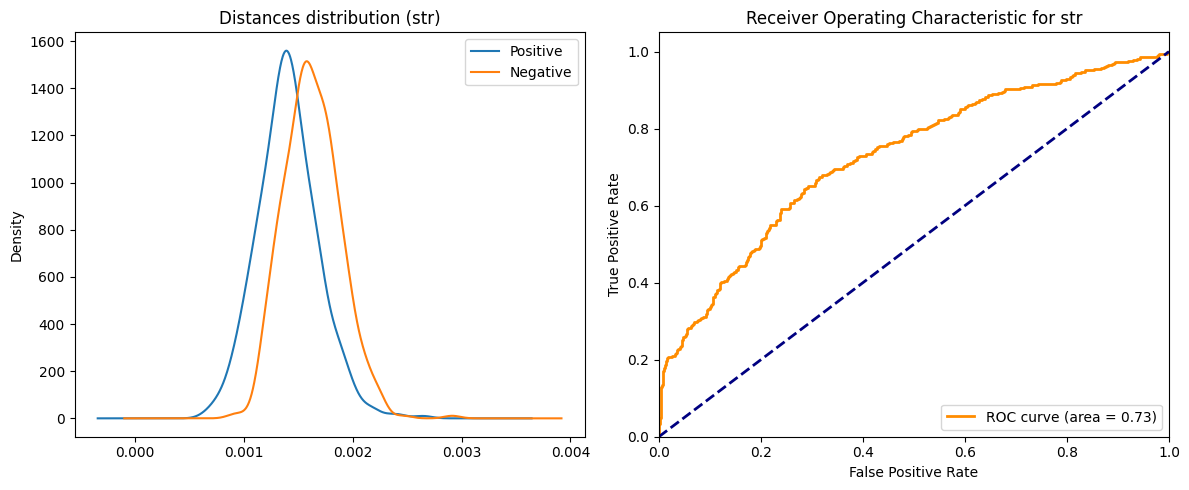

Target FAR: 1e-02 | Threshold: 0.0012
[epoch_13.pt] Accuracy: 0.5830
[epoch_13.pt] VAL: 0.1760 | FAR: 0.0100

[epoch_13.pt] Positive mean: 0.0014 ± 0.0003
[epoch_13.pt] Negative mean: 0.0016 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 71.22it/s]


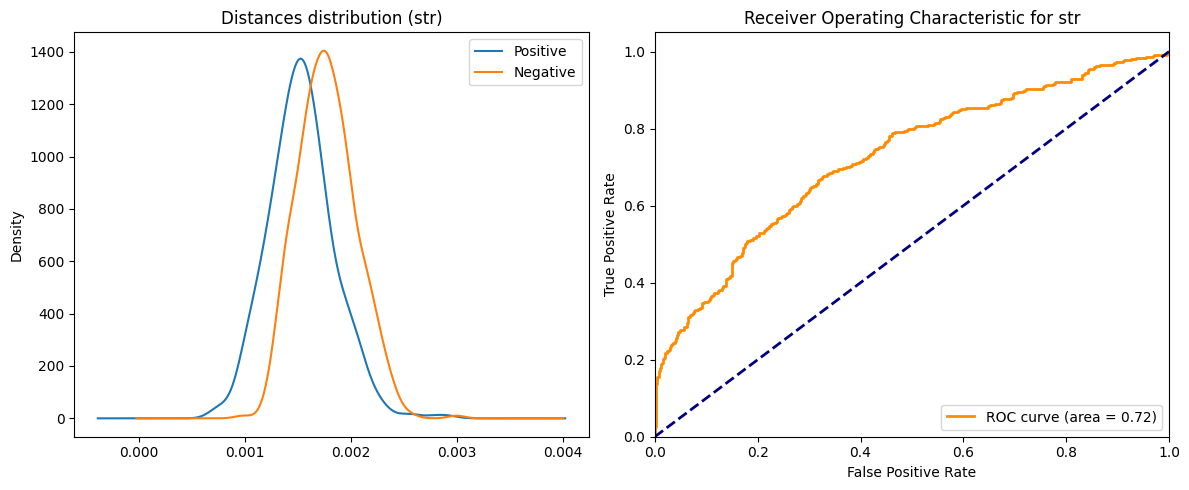

Target FAR: 1e-02 | Threshold: 0.0013
[epoch_14.pt] Accuracy: 0.5830
[epoch_14.pt] VAL: 0.1760 | FAR: 0.0100

[epoch_14.pt] Positive mean: 0.0015 ± 0.0003
[epoch_14.pt] Negative mean: 0.0018 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:02<00:00, 13.65it/s]


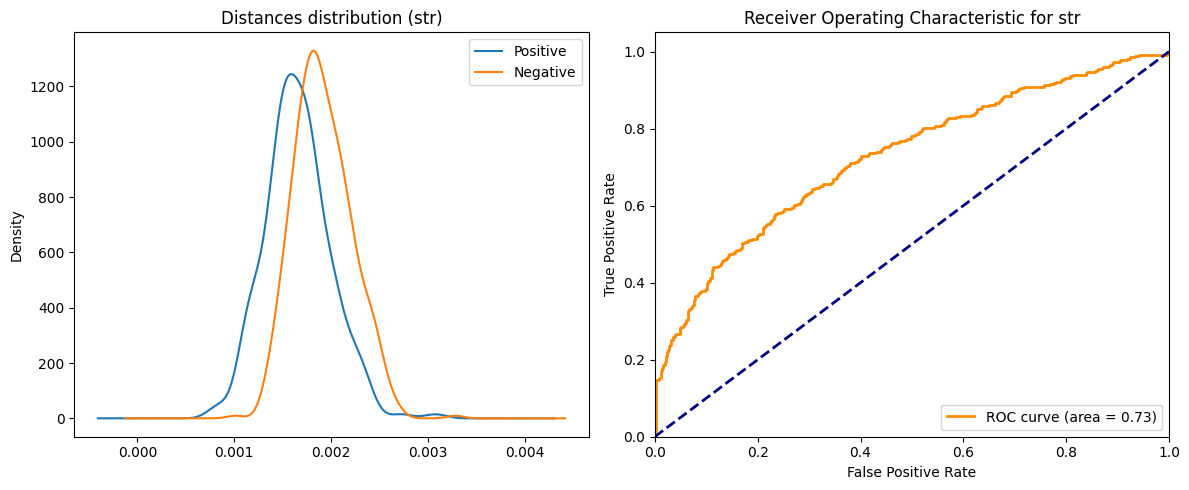

Target FAR: 1e-02 | Threshold: 0.0013
[epoch_15.pt] Accuracy: 0.5710
[epoch_15.pt] VAL: 0.1500 | FAR: 0.0080

[epoch_15.pt] Positive mean: 0.0017 ± 0.0003
[epoch_15.pt] Negative mean: 0.0019 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 53.50it/s]


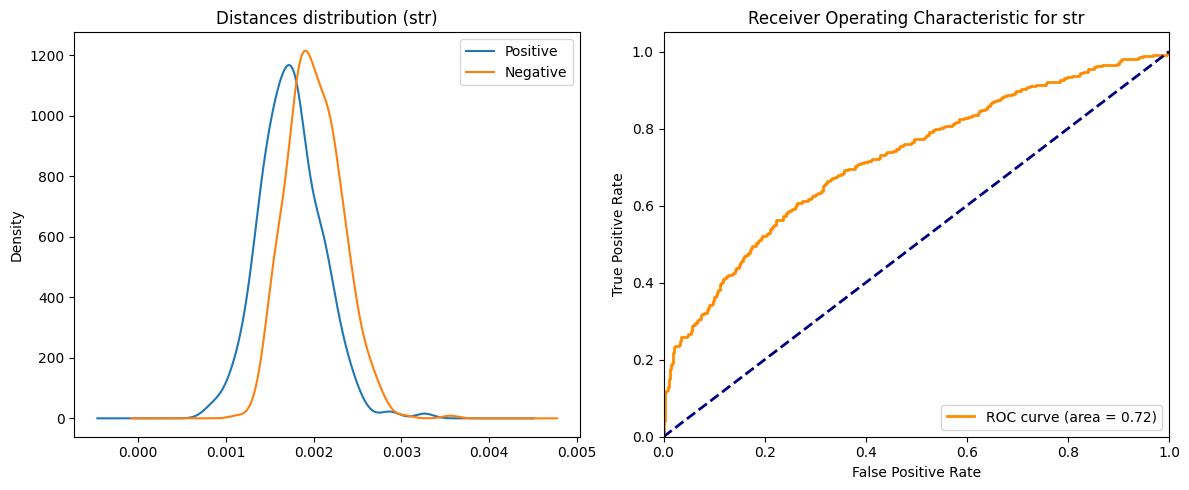

Target FAR: 1e-02 | Threshold: 0.0014
[epoch_16.pt] Accuracy: 0.5690
[epoch_16.pt] VAL: 0.1480 | FAR: 0.0100

[epoch_16.pt] Positive mean: 0.0017 ± 0.0004
[epoch_16.pt] Negative mean: 0.0020 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:01<00:00, 26.89it/s]


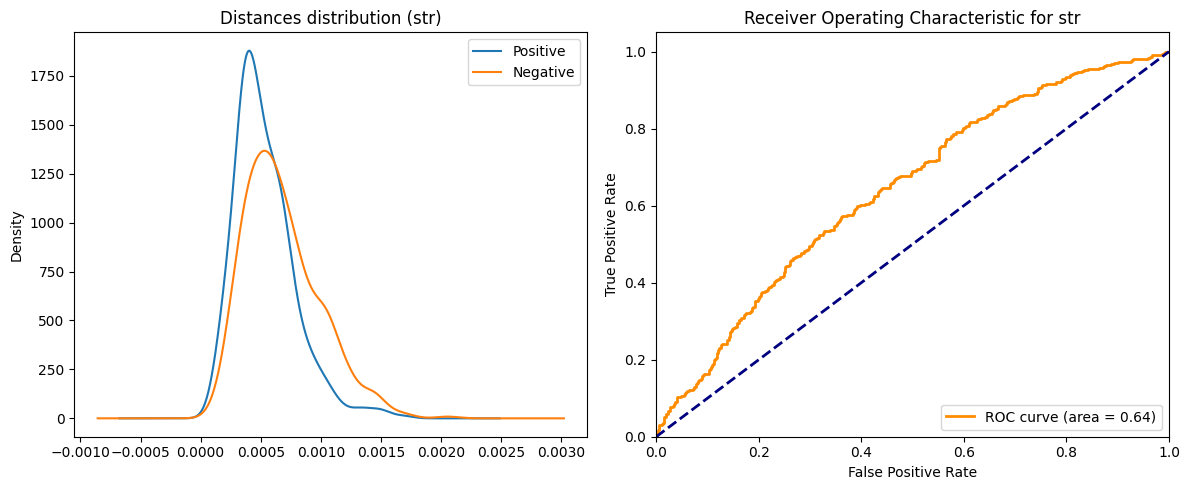

Target FAR: 1e-02 | Threshold: 0.0002
[epoch_20.pt] Accuracy: 0.5110
[epoch_20.pt] VAL: 0.0280 | FAR: 0.0060

[epoch_20.pt] Positive mean: 0.0005 ± 0.0003
[epoch_20.pt] Negative mean: 0.0007 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:01<00:00, 24.15it/s]


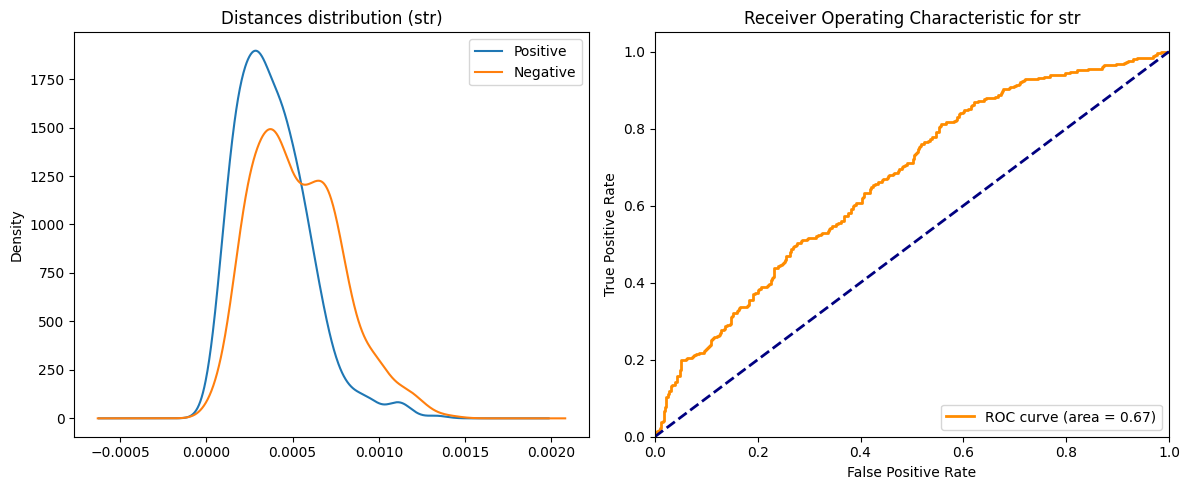

Target FAR: 1e-02 | Threshold: 0.0001
[epoch_25.pt] Accuracy: 0.5050
[epoch_25.pt] VAL: 0.0200 | FAR: 0.0100

[epoch_25.pt] Positive mean: 0.0004 ± 0.0002
[epoch_25.pt] Negative mean: 0.0005 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 54.63it/s]


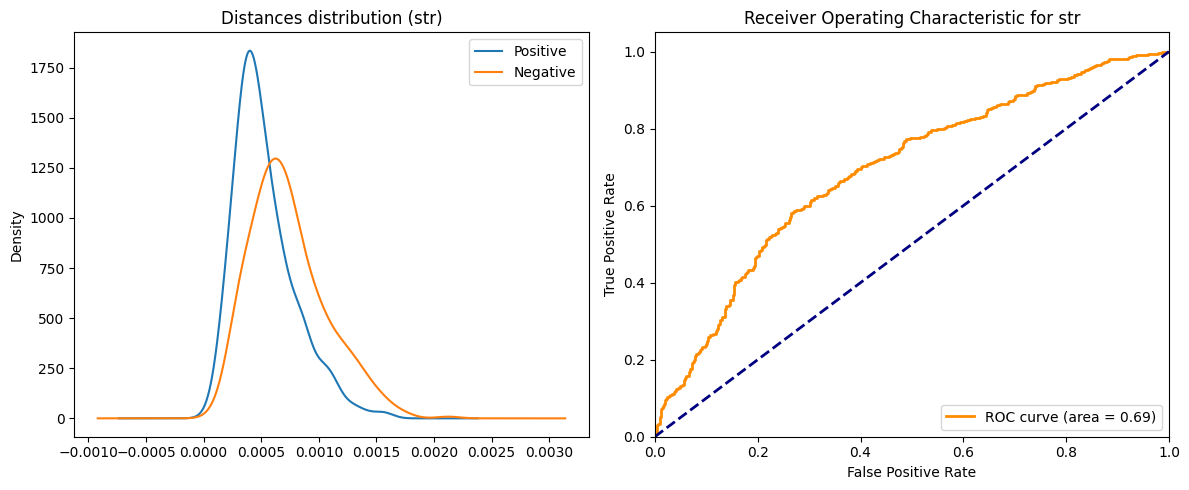

Target FAR: 1e-02 | Threshold: 0.0002
[epoch_30.pt] Accuracy: 0.5200
[epoch_30.pt] VAL: 0.0500 | FAR: 0.0100

[epoch_30.pt] Positive mean: 0.0005 ± 0.0003
[epoch_30.pt] Negative mean: 0.0007 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 73.08it/s]


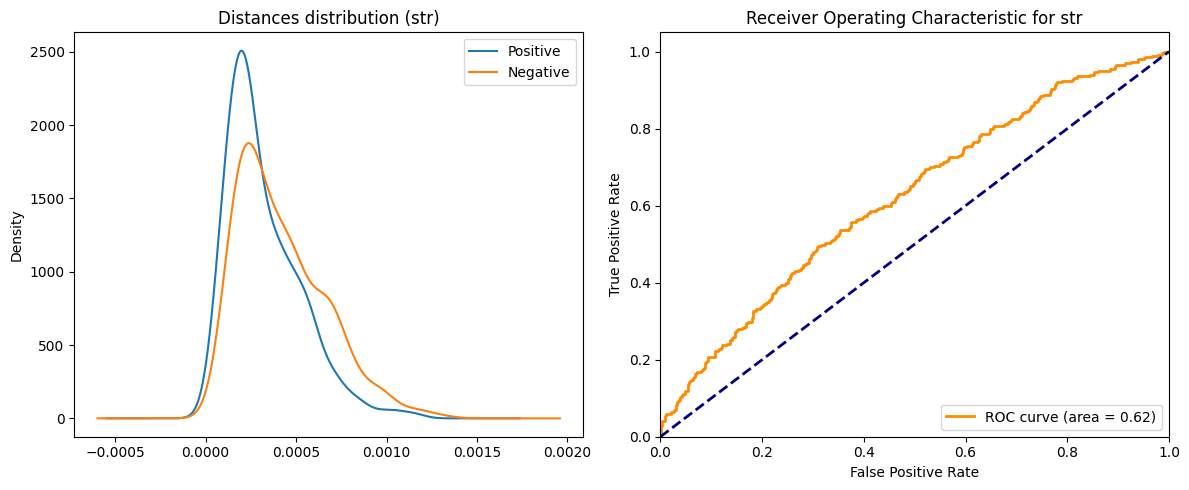

Target FAR: 1e-02 | Threshold: 0.0001
[epoch_35.pt] Accuracy: 0.5230
[epoch_35.pt] VAL: 0.0560 | FAR: 0.0100

[epoch_35.pt] Positive mean: 0.0003 ± 0.0002
[epoch_35.pt] Negative mean: 0.0004 ± 0.0002


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 75.04it/s]


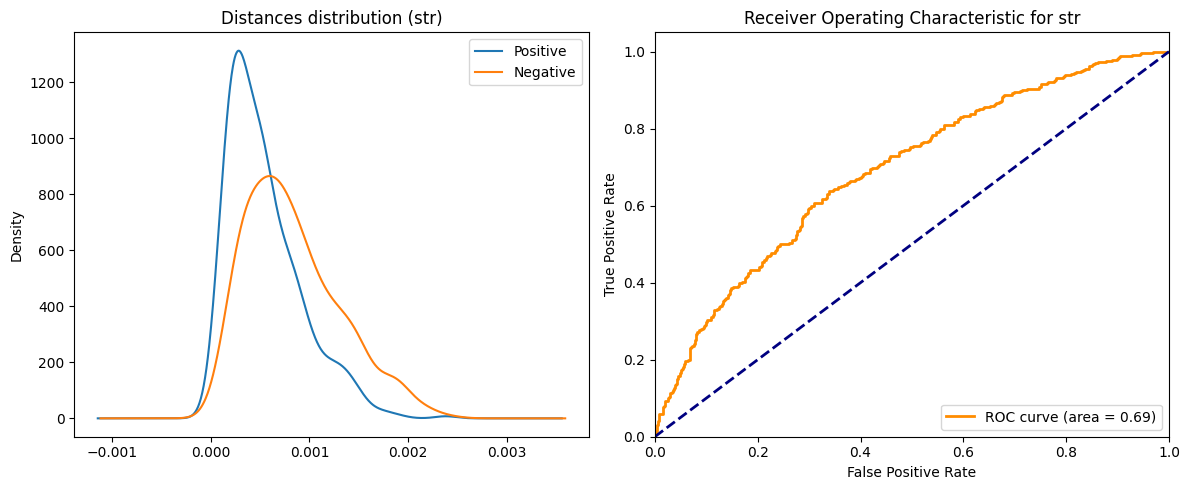

Target FAR: 1e-02 | Threshold: 0.0001
[epoch_40.pt] Accuracy: 0.5250
[epoch_40.pt] VAL: 0.0580 | FAR: 0.0080

[epoch_40.pt] Positive mean: 0.0005 ± 0.0004
[epoch_40.pt] Negative mean: 0.0008 ± 0.0005


In [4]:
eval_epochs(epochs_path=EPOCHS_PATH, 
            pairs=pairs,
            model_class=MiniInceptionResNetV1, 
            batch_size=32, 
            transform=simple_transform, 
            device=device,
            target_far=1e-2)